In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
# paths
StratACompPath = r'C:\Users\Leo Hubmann\Desktop\thesis\data\strategyA_returns_alloc.csv'
StratASinglePath = r'C:\Users\Leo Hubmann\Desktop\thesis\data\stratA_single_returns.csv' #  columns = stratAVader_ret, stratABert_ret, bh_ret
StratBCompPath = r'C:\Users\Leo Hubmann\Desktop\thesis\data\strat3_volacomp_alloc.csv'

In [4]:
price_path = r"C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv"
spx_path   = r"C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\sp500_2020_2025.csv"
cci_path   = r"C:\Users\Leo Hubmann\Desktop\thesis\prototype\cci30_OHLCV.csv"

In [5]:
START_DATE = "2021-01-01"
END_DATE = "2024-12-31"
TRAIN_END = "2023-12-31"
SHARPE_DAYS = 365
DCA_INVESTMENT_AMOUNT = 100  # Weekly investment amount, e.g., $100
DCA_FREQ = 'W-MON' # Monthly frequency, investing every Monday

In [6]:
dfA = pd.read_csv(StratACompPath, parse_dates=["date"]).set_index("date")
dfAs = pd.read_csv(StratASinglePath, parse_dates=["date"]).set_index("date")          # VADER/BERT/BH
dfB = pd.read_csv(StratBCompPath, parse_dates=["date"]).set_index("date")

In [7]:
dfA = dfA.rename(columns={"strat_ret": "stratA_comp"})
dfB = dfB.rename(columns={"stratB_ret": "stratB_comp"})
df = dfA.join([dfAs, dfB], how="inner").sort_index()      # align on common dates

In [8]:
# load price series
btc_price = (pd.read_csv(price_path, parse_dates=["date"])
               .set_index("date")["close"]
               .loc["2020-12-31":END_DATE])

spx_price = (pd.read_csv(spx_path, parse_dates=["date"])
               .set_index("date")["close"]
               .loc["2020-12-31":END_DATE])

cci_price = (pd.read_csv(cci_path, parse_dates=["Date"])
               .set_index("Date")
               .sort_index()                            # <- this fixes the error
               ["Close"]
               .loc["2020-12-31":END_DATE])

In [9]:
# daily log returns
btc_ret = np.log(btc_price).diff().rename("ret_btc")
spx_ret = np.log(spx_price).diff().rename("ret_spx")
cci_ret = np.log(cci_price).diff().rename("ret_cci")

In [10]:
def calculate_dca_returns(price_series, investment_amount, freq):
    """
    Calculates the daily log returns of a Dollar Cost Averaging (DCA) strategy,
    correctly adjusting for periodic cash inflows.
    """
    dca_df = price_series.to_frame(name='price')
    investment_days = dca_df.resample(freq).first().index
    dca_df['investments'] = 0.0
    valid_investment_days = dca_df.index.intersection(investment_days)
    dca_df.loc[valid_investment_days, 'investments'] = investment_amount
    dca_df['units_purchased'] = dca_df['investments'] / dca_df['price']
    dca_df['cumulative_units'] = dca_df['units_purchased'].cumsum()
    dca_df['portfolio_value'] = dca_df['cumulative_units'] * dca_df['price']
    numerator = dca_df['portfolio_value'] - dca_df['investments']
    denominator = dca_df['portfolio_value'].shift(1)
    numerator = numerator.where(numerator > 0)
    denominator = denominator.where(denominator > 0)
    dca_returns = (np.log(numerator) - np.log(denominator)).rename("ret_dca_btc")
    return dca_returns

In [11]:
# 1. Continuous DCA for Full/IS period analysis
dca_ret_continuous = calculate_dca_returns(
    price_series=btc_price,
    investment_amount=DCA_INVESTMENT_AMOUNT,
    freq=DCA_FREQ
)

In [12]:
# 2. OOS-Reset DCA for OOS period analysis
OOS_START_DATE = pd.to_datetime(TRAIN_END) + pd.Timedelta(days=1)
price_oos = btc_price.loc[OOS_START_DATE:]
dca_ret_oos_reset = calculate_dca_returns(
    price_series=price_oos,
    investment_amount=DCA_INVESTMENT_AMOUNT,
    freq=DCA_FREQ
)

In [13]:
dfs = [df, btc_ret, spx_ret, cci_ret, dca_ret_continuous]
df  = pd.concat(dfs, axis=1).loc[START_DATE:END_DATE]

df.iloc[0] = df.iloc[0].fillna(0)
df = df.fillna(0)

In [14]:
def ann_sharpe(r, days=SHARPE_DAYS):
    r = r.dropna()
    return np.sqrt(days) * r.mean() / r.std()

def max_dd(r):
    eq = np.exp(r.fillna(0).cumsum())
    return (1 - eq/eq.cummax()).max()

def cum_curve(r):
    return np.exp(r.cumsum())

In [15]:
cols = ["stratA_comp", "stratB_comp",
        "stratAVader_ret", "stratABert_ret",
        "ret_btc", "ret_spx", "ret_cci", "ret_dca_btc"]

In [16]:
is_mask  = df.index <= TRAIN_END
oos_mask = df.index >  TRAIN_END

def stats(lbl, series):
    return pd.Series({
        "Total Ret": cum_curve(series).iloc[-1] - 1,
        "Ann Vol":   series.std()*np.sqrt(SHARPE_DAYS),
        "Sharpe":    ann_sharpe(series),
        "Max DD":    max_dd(series)
    }, name=lbl)

def build_perf_table(df_slice, label):
    if df_slice.empty:
        return pd.DataFrame()
    # Filter for columns present in the slice
    slice_cols = [c for c in cols if c in df_slice.columns]
    return pd.concat({c: stats(c, df_slice[c]) for c in slice_cols}, axis=1).T\
             .assign(Sample=label)\
             .set_index("Sample", append=True)\
             .swaplevel()

# Build Performance Tables with Correct DCA Logic
tbl_full = build_perf_table(df, "Full").round(2)
tbl_IS   = build_perf_table(df[is_mask], "IS").round(2)
df_oos_slice = df[oos_mask].copy()
df_oos_slice['ret_dca_btc'] = dca_ret_oos_reset
tbl_OOS  = build_perf_table(df_oos_slice, "OOS").round(2)

print("\n--- Full Period Performance (from continuous simulation) ---")
display(tbl_full)
print("\n--- In-Sample Performance (from continuous simulation) ---")
display(tbl_IS)
print("\n--- Out-of-Sample Performance (from reset simulation) ---")
display(tbl_OOS)


--- Full Period Performance (from continuous simulation) ---


Total Ret  Ann Vol  Sharpe  Max DD
Sample                                                    
Full   stratA_comp           1.94     0.29    0.91    0.59
       stratB_comp           1.59     0.26    0.91    0.57
       stratAVader_ret       1.67     0.33    0.75    0.53
       stratABert_ret        1.31     0.32    0.66    0.64
       ret_btc               2.22     0.62    0.47    0.77
       ret_spx               0.57     0.16    0.68    0.25
       ret_cci               1.83     0.73    0.36    0.83
       ret_dca_btc           1.92     0.62    0.43    0.77


--- In-Sample Performance (from continuous simulation) ---


Total Ret  Ann Vol  Sharpe  Max DD
Sample                                                    
IS     stratA_comp           0.21     0.28    0.22    0.59
       stratB_comp           0.08     0.24    0.10    0.57
       stratAVader_ret       0.42     0.31    0.37    0.53
       stratABert_ret        0.06     0.29    0.07    0.64
       ret_btc               0.46     0.65    0.19    0.77
       ret_spx               0.27     0.18    0.45    0.25
       ret_cci               0.59     0.77    0.20    0.83
       ret_dca_btc           0.32     0.64    0.14    0.77


--- Out-of-Sample Performance (from reset simulation) ---


Total Ret  Ann Vol  Sharpe  Max DD
Sample                                                    
OOS    stratA_comp           1.43     0.33    2.70    0.14
       stratB_comp           1.41     0.31    2.83    0.12
       stratAVader_ret       0.88     0.37    1.71    0.26
       stratABert_ret        1.18     0.38    2.03    0.25
       ret_btc               1.21     0.53    1.49    0.26
       ret_spx               0.23     0.13    1.65    0.08
       ret_cci               0.78     0.58    1.00    0.40
       ret_dca_btc           1.12     0.53    1.41    0.26

In [17]:
print("\n--- OOS Strategy A Variants Performance Comparison ---")

# Define the columns for the strategies to be compared
cols_A_variants = ['stratA_comp', 'stratAVader_ret', 'stratABert_ret']

# Check if all required columns exist
if all(col in df.columns for col in cols_A_variants):
    # Use the existing build_perf_table function by temporarily overriding the 'cols' list
    # This is a clean way to reuse the function for a specific subset of columns.
    original_cols = cols
    cols = cols_A_variants
    
    tbl_A_variants_OOS = build_perf_table(df[oos_mask], "OOS").round(2)
    display(tbl_A_variants_OOS)
    
    # Restore the original columns list for any subsequent analysis
    cols = original_cols
else:
    print("Could not generate the Strategy A variants performance table.")
    print("Please ensure your data contains the following columns:")
    missing_cols = [col for col in cols_A_variants if col not in df.columns]
    print(f"Missing columns: {missing_cols}")


--- OOS Strategy A Variants Performance Comparison ---


Total Ret  Ann Vol  Sharpe  Max DD
Sample                                                    
OOS    stratA_comp           1.43     0.33    2.70    0.14
       stratAVader_ret       0.88     0.37    1.71    0.26
       stratABert_ret        1.18     0.38    2.03    0.25

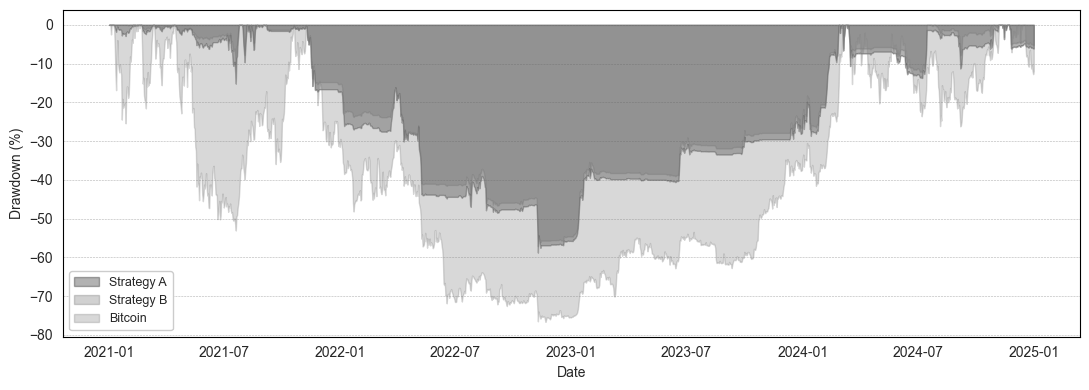

In [18]:
def compute_drawdown(returns):
    """
    Compute drawdown series from returns.
    CORRECTED: This now correctly handles log returns by using np.exp().
    """
    # Convert log returns to an equity curve
    cum_returns = np.exp(returns.fillna(0).cumsum())
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown

# Create underwater plot
fig, ax = plt.subplots(figsize=(11, 4))

# Calculate drawdowns for main strategies
# CORRECTED: Using 'ret_btc' for clarity and to ensure it exists.
strategies = {
    'Strategy A': df['stratA_comp'],
    'Strategy B': df['stratB_comp'],
    'Bitcoin': df['ret_btc']
}

greys = ["black", "dimgray", "gray", "lightgray"]
if len(strategies) > len(greys):
    greys += ["silver"] * (len(strategies) - len(greys))

for (name, returns), color in zip(strategies.items(), greys):
    dd = compute_drawdown(returns)
    ax.fill_between(dd.index, 0, dd * 100, alpha=0.3, label=name, color=color)

for sp in ("top", "right", "left", "bottom"):
    ax.spines[sp].set_color("black")

ax.set_ylabel('Drawdown (%)')
ax.set_xlabel('Date')
ax.legend(frameon=True, framealpha=1, fontsize=9)
ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax.grid(False, axis='x')
plt.tight_layout()
plt.savefig("drawdownA_B.png", dpi=300, bbox_inches="tight")
plt.show()

In [353]:
def calculate_risk_metrics(returns):
    """
    Calculate comprehensive risk metrics, now including average drawdown and recovery.
    """
    dd_series = compute_drawdown(returns)
    
    # Identify individual drawdown periods
    underwater = dd_series < 0
    
    # Handle case with no drawdowns
    if not underwater.any():
        avg_dd = 0
        avg_recovery_days = 0
        max_dd_duration = 0
    else:
        # Group by each drawdown event
        drawdown_groups = underwater.ne(underwater.shift()).cumsum()
        underwater_groups = drawdown_groups[underwater]

        # Calculate duration of each drawdown
        recovery_times = underwater_groups.value_counts()
        avg_recovery_days = recovery_times.mean()
        max_dd_duration = recovery_times.max()

        # Calculate peak drawdown for each event
        peak_drawdowns = dd_series.groupby(underwater_groups).min()
        avg_dd = peak_drawdowns.mean()

    max_dd = -dd_series.min() if not dd_series.empty else 0
    
    positive_days = (returns > 0).sum()
    total_days = len(returns[returns != 0])
    win_rate = positive_days / total_days if total_days > 0 else 0
    
    gains = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    profit_factor = gains / losses if losses > 0 else np.inf
    
    vol_by_year = {}
    for year in ['2021', '2022', '2023', '2024']:
        if year in returns.index.year.astype(str):
            vol_by_year[f'Vol {year} (%)'] = returns.loc[year].std() * np.sqrt(365) * 100
        else:
            vol_by_year[f'Vol {year} (%)'] = 0

    risk_series = pd.Series({
        'Max Drawdown (%)': max_dd * 100,
        'Average Drawdown (%)': -avg_dd * 100, # avg_dd is negative, so invert
        'Max DD Duration (days)': max_dd_duration,
        'Avg Recovery (days)': avg_recovery_days,
        'Win Rate (%)': win_rate * 100,
        'Profit Factor': profit_factor,
    })
    
    risk_series = pd.concat([risk_series, pd.Series(vol_by_year)])
    return risk_series

# Create risk metrics table from a dictionary and transpose it.
risk_metrics_data = {
    'Strategy A': calculate_risk_metrics(df['stratA_comp']),
    'Strategy B': calculate_risk_metrics(df['stratB_comp']),
    'Bitcoin': calculate_risk_metrics(df['ret_btc'])
}
risk_table = pd.DataFrame(risk_metrics_data).T

print("\nTable 5.2: Risk Metrics Comparison")
display(risk_table.round(2))


Table 5.2: Risk Metrics Comparison


,Max Drawdown (%),Average Drawdown (%),Max DD Duration (days),Avg Recovery (days),Win Rate (%),Profit Factor,Vol 2021 (%),Vol 2022 (%),Vol 2023 (%),Vol 2024 (%)
Strategy A,58.77,5.63,903.0,56.12,49.10,1.25,26.39,35.96,19.58,32.81
Strategy B,57.10,4.13,903.0,44.13,48.99,1.27,19.44,31.35,19.42,30.91
Bitcoin,76.63,12.65,846.0,64.32,49.97,1.07,80.32,64.22,43.28,53.13


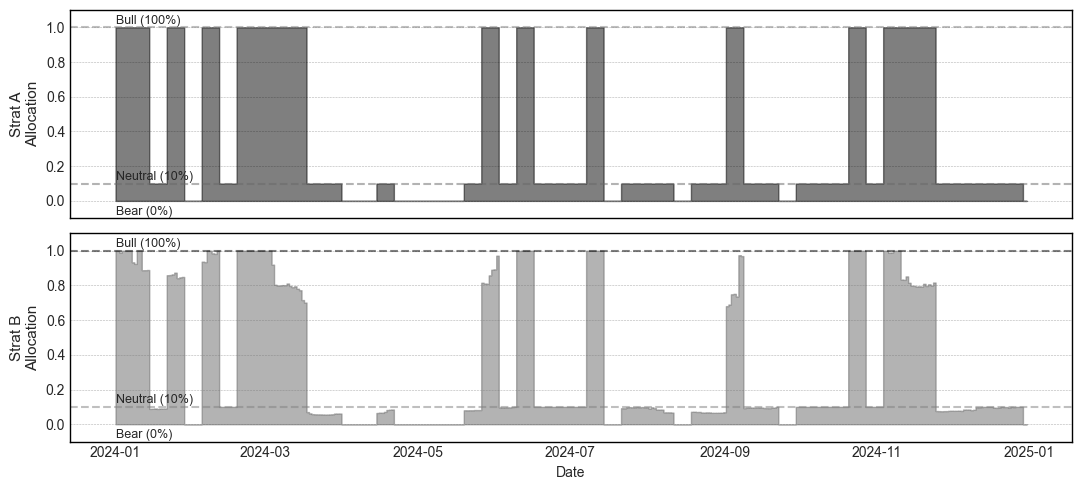

In [176]:
# Out-of-Sample Performance and Allocation Dynamics (2024)


# Define greys palette
greys = ["black", "dimgray", "gray", "lightgray"]

# Ensure enough colors for all panels
if len(greys) < 3:
    greys += ["silver"] * (3 - len(greys))

oos_mask = df.index > '2023-12-31'
df_oos = df[oos_mask]

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True, 
#                                     gridspec_kw={'height_ratios': [2, 1, 1]})
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(11, 5), sharex=True, 
                                    gridspec_kw={'height_ratios': [1, 1]})

# Top panel: Cumulative returns
cum_returns_a = cum_curve(df_oos['stratA_comp'])
cum_returns_b = cum_curve(df_oos['stratB_comp'])
cum_returns_bh = cum_curve(df_oos['bh_ret'])

# ax1.plot(df_oos.index, cum_returns_bh, label='Buy & Hold', alpha=0.7, color=greys[0])
# ax1.plot(df_oos.index, cum_returns_a, label='Strategy A', linewidth=2, linestyle='--', color=greys[1])
# ax1.plot(df_oos.index, cum_returns_b, label='Strategy B', linewidth=2, linestyle=':', color=greys[2])
# ax1.set_ylabel('Cumulative Growth', fontsize=11)
# ax1.legend()
# ax1.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
# ax1.grid(False, axis='x')
# ax1.legend(frameon=True, framealpha=1, fontsize=9, loc="upper left")


# Middle panel: Strategy A allocation
ax2.fill_between(df_oos.index, 0, df_oos['alloc'], alpha=0.5, color=greys[0], step='mid')
ax2.axhline(y=0.1, color=greys[1], linestyle='--', alpha=0.5)
ax2.axhline(y=1.0, color=greys[2], linestyle='--', alpha=0.5)
ax2.text(df_oos.index[0], 1.02, 'Bull (100%)', fontsize=9)
ax2.text(df_oos.index[0], 0.12, 'Neutral (10%)', fontsize=9)
ax2.text(df_oos.index[0], -0.08, 'Bear (0%)', fontsize=9)
ax2.set_ylabel('Strat A\nAllocation', fontsize=11)
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax2.grid(False, axis='x')

# Bottom panel: Strategy B allocation
ax3.fill_between(df_oos.index, 0, df_oos['allocB'], alpha=0.5, color=greys[1], step='mid')
ax3.axhline(y=0.1, color=greys[2], linestyle='--', alpha=0.5)
ax3.axhline(y=1.0, color=greys[0], linestyle='--', alpha=0.5)
ax3.text(df_oos.index[0], 1.02, 'Bull (100%)', fontsize=9)
ax3.text(df_oos.index[0], 0.12, 'Neutral (10%)', fontsize=9)
ax3.text(df_oos.index[0], -0.08, 'Bear (0%)', fontsize=9)
ax3.set_ylabel('Strat B\nAllocation', fontsize=11)
ax3.set_xlabel('Date')
ax3.set_ylim(-0.1, 1.1)
ax3.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax3.grid(False, axis='x')

# Add vertical line for IS/OOS split
sp = ["top", "right", "left", "bottom"]
for ax in [ax2, ax3]:
    ax.spines[sp].set_color('black')

plt.tight_layout()
plt.savefig("OOSAllocation_B.png", dpi=300, bbox_inches="tight")
plt.show()

In [177]:
alloc_a_regimes = pd.cut(df['alloc'], bins=[-0.1, 0.05, 0.5, 1.1], labels=['Bear', 'Neutral', 'Bull'])
alloc_b_regimes = pd.cut(df['allocB'], bins=[-0.1, 0.05, 0.5, 1.1], labels=['Bear', 'Neutral', 'Bull'])

print("\nRegime Distribution - Strategy A:")
print(alloc_a_regimes.value_counts(normalize=True).sort_index() * 100)

print("\nRegime Distribution - Strategy B:")
print(alloc_b_regimes.value_counts(normalize=True).sort_index() * 100)

# Calculate average allocation
print(f"\nAverage Allocation - Strategy A: {df['alloc'].mean():.2%}")
print(f"Average Allocation - Strategy B: {df['allocB'].mean():.2%}")


Regime Distribution - Strategy A:
alloc
Bear       25.256674
Neutral    49.349760
Bull       25.393566
Name: proportion, dtype: float64

Regime Distribution - Strategy B:
allocB
Bear       32.306639
Neutral    42.573580
Bull       25.119781
Name: proportion, dtype: float64

Average Allocation - Strategy A: 30.33%
Average Allocation - Strategy B: 25.88%


In [354]:
print("\n--- OOS Regime Distribution Table ---")
if 'alloc' in df_oos.columns and 'allocB' in df_oos.columns:
    # Define regime bins and labels
    bins = [-0.1, 0.05, 0.5, 1.1]
    labels = ['Bear', 'Neutral', 'Bull']
    
    # Calculate regime distributions for the OOS period
    alloc_a_regimes_oos = pd.cut(df_oos['alloc'], bins=bins, labels=labels)
    alloc_b_regimes_oos = pd.cut(df_oos['allocB'], bins=bins, labels=labels)

    dist_a = alloc_a_regimes_oos.value_counts(normalize=True).sort_index() * 100
    dist_b = alloc_b_regimes_oos.value_counts(normalize=True).sort_index() * 100
    
    # Create the distribution DataFrame
    oos_dist_table = pd.DataFrame({'Strategy A': dist_a, 'Strategy B': dist_b}).T
    
    # Calculate and add average allocation
    oos_dist_table['Average Allocation (%)'] = [
        df_oos['alloc'].mean() * 100,
        df_oos['allocB'].mean() * 100
    ]
    
    # Rename columns for clarity
    oos_dist_table = oos_dist_table.rename(columns={
        'Bear': 'Bear (%)', 'Neutral': 'Neutral (%)', 'Bull': 'Bull (%)'
    })
    
    display(oos_dist_table.round(2))
else:
    print("Allocation columns ('alloc', 'allocB') not found. Skipping table.")



--- OOS Regime Distribution Table ---


,Bear (%),Neutral (%),Bull (%),Average Allocation (%)
Strategy A,19.67,49.73,30.6,35.57
Strategy B,19.67,49.73,30.6,32.36


In [275]:
def plot_cum_returns_bw(df, cols, split_date=None, title=None,
                        filename=None, linestyles=None, labels=None):
    """
    df        : DataFrame with cumulative-return *factors* (1 = flat)
    cols      : ordered list of column names to plot
    split_date: draw vertical line (train–test boundary) if provided
    linestyles: optional list of matplotlib line-style strings (e.g. ['-', '--', ':', '-.'])
    labels    : custom legend labels (optional, same order as cols)
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(11, 4))

    # default grey palette (darker -> lighter)
    greys = ["black", "dimgray", "gray", "darkgray"]
    if len(cols) > len(greys):
        greys += ["silver"] * (len(cols) - len(greys))
    if linestyles is None:
        linestyles = ['-'] * len(cols)
    if labels is None:
        labels = cols

    # plot each series
    for col, c, ls, lbl in zip(cols, greys, linestyles, labels):
        df[col].sub(1).plot(ax=ax, lw=1, color=c, linestyle=ls, label=lbl)

    # train–test boundary
    if split_date is not None:
        ax.axvline(pd.to_datetime(split_date), ls="--", color="dimgray", alpha=.7)

    # ── styling ───────────────────────────────────────────────
    ax.set_ylabel("Cumulative return", fontsize=11)
    ax.set_xlabel("Date", fontsize=11)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=12))

    for sp in ("top", "right", "left", "bottom"):
        ax.spines[sp].set_color("black")

    ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
    ax.grid(False, axis='x')

    ax.legend(frameon=True, framealpha=1, fontsize=9, loc="upper left")
    if title:
        ax.set_title(title, fontsize=12, pad=8)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


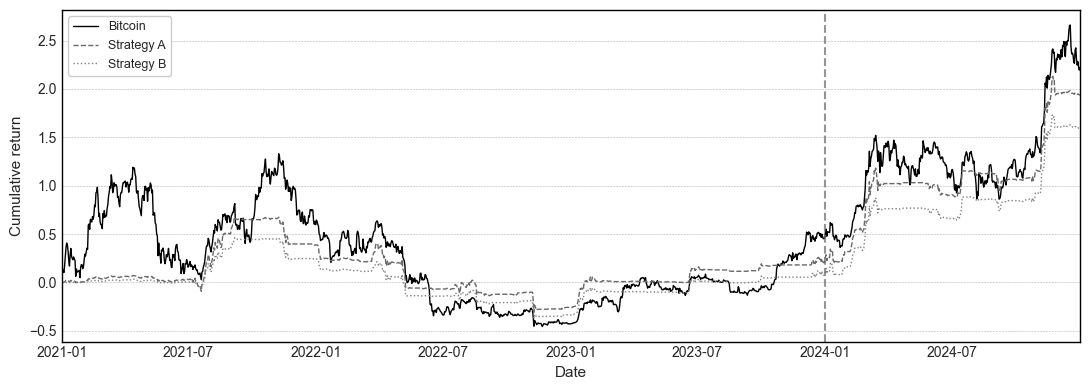

In [276]:
plot_cols = ["ret_btc", "stratA_comp", "stratB_comp"]
plot_labels = ["Bitcoin", "Strategy A", "Strategy B"]

plot_cum_returns_bw(
    df=cum_curve(df[plot_cols]),
    cols=plot_cols,
    labels=plot_labels,           # NEW
    split_date=TRAIN_END,
    filename="fig_returnsA_B.png",
    linestyles=["-", "--", ":"]
)

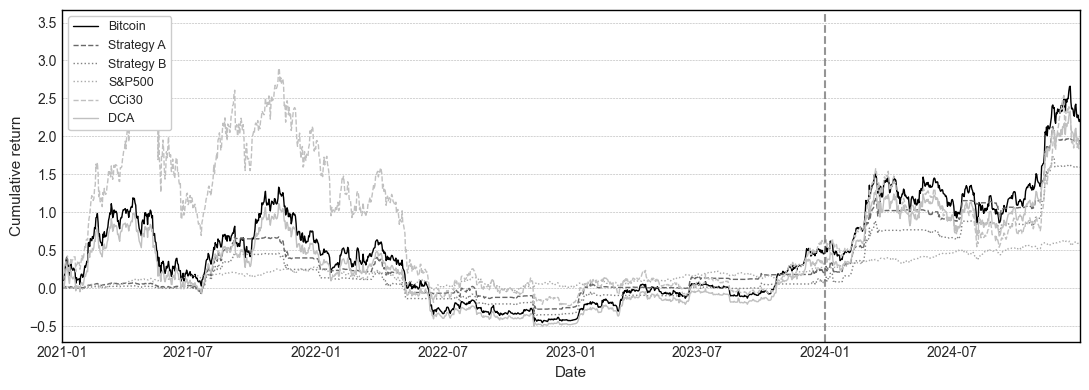

In [277]:
plot_cols = ["ret_btc", "stratA_comp", "stratB_comp", "ret_spx", "ret_cci", "ret_dca_btc"]
plot_labels = ["Bitcoin", "Strategy A", "Strategy B", "S&P500", "CCi30", "DCA"]

plot_cum_returns_bw(
    df=cum_curve(df[plot_cols]),
    cols=plot_cols,
    labels=plot_labels,           # NEW
    split_date=TRAIN_END,
    filename="fig_returnsFULLall.png",
    linestyles=["-", "--", ":", ":", "--", "-"]
)

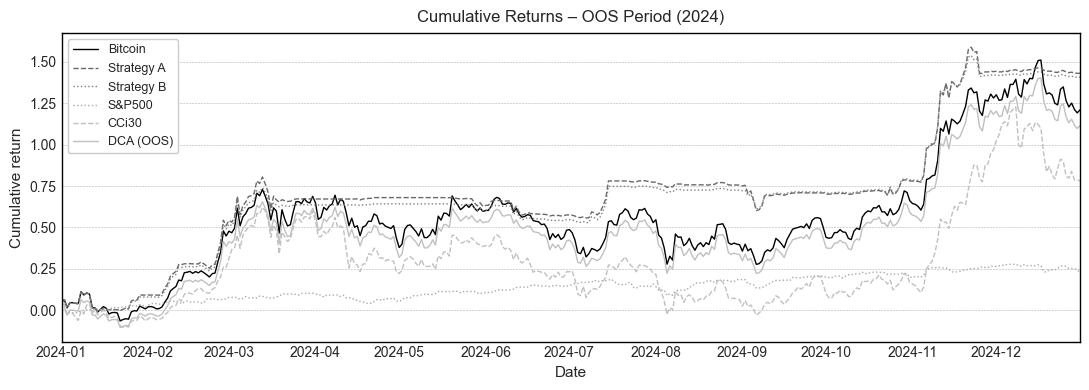

In [270]:
oos_df = df.loc[oos_mask].copy()

oos_df['ret_dca_btc'] = dca_ret_oos_reset

plot_cols = ["ret_btc", "stratA_comp", "stratB_comp", "ret_spx", "ret_cci", "ret_dca_btc"]
plot_labels = ["Bitcoin", "Strategy A", "Strategy B", "S&P500", "CCi30", "DCA (OOS)"]

oos_cum_returns = cum_curve(oos_df[plot_cols])

plot_cum_returns_bw(
    df=oos_cum_returns,
    cols=plot_cols,
    labels=plot_labels,
    linestyles=["-", "--", ":", ":", "--", "-"],
    split_date=None,
    title="Cumulative Returns – OOS Period (2024)",
    filename="fig_returnsOOS_all.png"
)

In [279]:
def plot_cum_returns_bw(df, cols, split_date=None, title=None,
                        filename=None, linestyles=None, labels=None,
                        linewidths=None): # Added linewidths parameter
    """
    df        : DataFrame with cumulative-return *factors* (1 = flat)
    cols      : ordered list of column names to plot
    split_date: draw vertical line (train–test boundary) if provided
    linestyles: optional list of matplotlib line-style strings (e.g. ['-', '--', ':', '-.'])
    labels    : custom legend labels (optional, same order as cols)
    linewidths: custom line widths (optional, same order as cols)
    """
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(11, 4))

    # default grey palette (darker -> lighter)
    greys = ["black", "dimgray", "gray", "darkgray", "silver", "lightgray"]
    if len(cols) > len(greys):
        greys += ["silver"] * (len(cols) - len(greys))
    if linestyles is None:
        linestyles = ['-'] * len(cols)
    if labels is None:
        labels = cols
    # Added default for linewidths
    if linewidths is None:
        linewidths = [1] * len(cols)

    # plot each series, now with linewidth control
    for col, c, ls, lw, lbl in zip(cols, greys, linestyles, linewidths, labels):
        (df[col] - 1).plot(ax=ax, lw=lw, color=c, linestyle=ls, label=lbl)

    # train–test boundary
    if split_date is not None:
        ax.axvline(pd.to_datetime(split_date), ls="--", color="dimgray", alpha=.7)

    # ── styling (preserved from your original function) ──
    ax.set_ylabel("Cumulative return", fontsize=11)
    ax.set_xlabel("Date", fontsize=11)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=12))

    # This keeps your desired border style
    for sp in ("top", "right", "left", "bottom"):
        ax.spines[sp].set_color("black")

    ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
    ax.grid(False, axis='x')

    ax.legend(frameon=True, framealpha=1, fontsize=9, loc="upper left")
    if title:
        ax.set_title(title, fontsize=12, pad=8)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

--- Plotting Full Period Performance ---


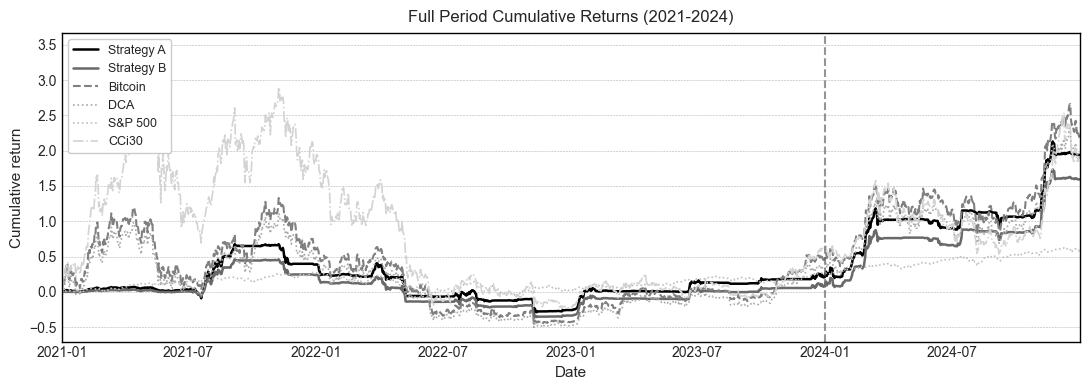

In [280]:
# --- Plotting Call for Full Period (with improved styles) ---
print("--- Plotting Full Period Performance ---")
plot_cols = ["stratA_comp", "stratB_comp", "ret_btc", "ret_dca_btc", "ret_spx", "ret_cci"]
plot_labels = ["Strategy A", "Strategy B", "Bitcoin", "DCA", "S&P 500", "CCi30"]
plot_linestyles = ['-', '-', '--', ':', ':', '-.']
# Define linewidths to make strategies stand out
plot_linewidths = [1.8, 1.8, 1.5, 1.2, 1.2, 1.2]

plot_cum_returns_bw(
    df=cum_curve(df[plot_cols]),
    cols=plot_cols,
    labels=plot_labels,
    linewidths=plot_linewidths, # Pass the linewidths
    linestyles=plot_linestyles,
    split_date=TRAIN_END,
    title="Full Period Cumulative Returns (2021-2024)",
    filename="fig_returns_FULL_improved.png"
)


--- Plotting Out-of-Sample Performance ---


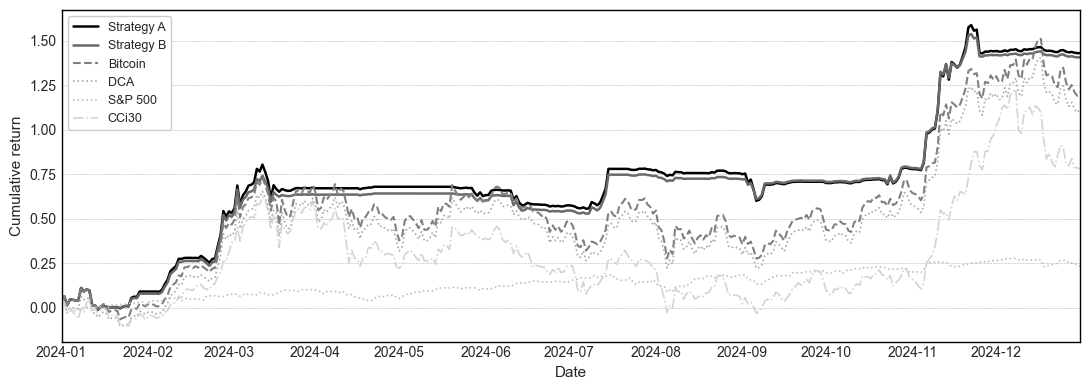

In [282]:

# --- Plotting Call for OOS Period (with improved styles) ---
print("\n--- Plotting Out-of-Sample Performance ---")
oos_mask = df.index > TRAIN_END
oos_df = df.loc[oos_mask].copy()
oos_df['ret_dca_btc'] = dca_ret_oos_reset
oos_cum_returns = cum_curve(oos_df[plot_cols])

plot_cum_returns_bw(
    df=oos_cum_returns,
    cols=plot_cols,
    labels=plot_labels,
    linewidths=plot_linewidths, # Pass the linewidths
    linestyles=plot_linestyles,
    # title="Out-of-Sample Cumulative Returns (2024)",
    filename="fig_returns_OOS_improved.png"
)

--- Plotting Full Period Performance ---


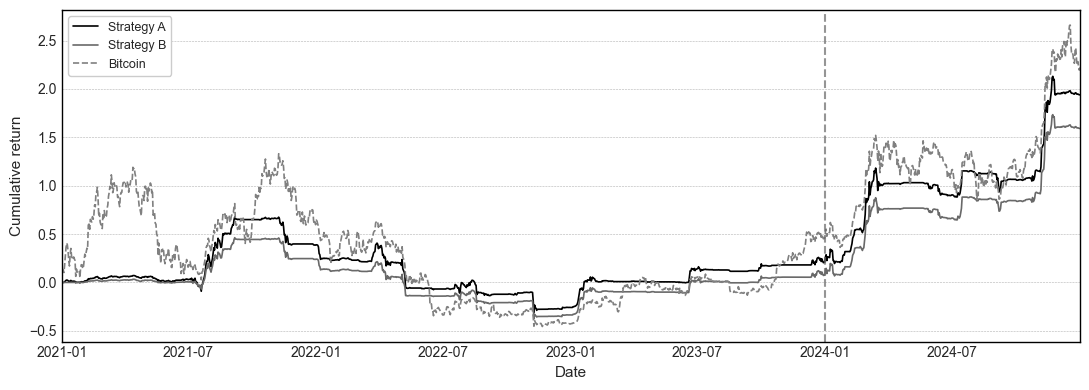

In [358]:
# --- Plotting Call for Full Period (with improved styles) ---
print("--- Plotting Full Period Performance ---")
plot_cols = ["stratA_comp", "stratB_comp", "ret_btc"]
plot_labels = ["Strategy A", "Strategy B", "Bitcoin"]
plot_linestyles = ['-', '-', '--', ':', ':', '-.']
# Define linewidths to make strategies stand out
plot_linewidths = [1.2, 1.2, 1.2]

plot_cum_returns_bw(
    df=cum_curve(df[plot_cols]),
    cols=plot_cols,
    labels=plot_labels,
    linewidths=plot_linewidths, # Pass the linewidths
    linestyles=plot_linestyles,
    split_date=TRAIN_END,
    # title="Full Period Cumulative Returns (2021-2024)",
    filename="fig_returns_FULL_improved.png"
)

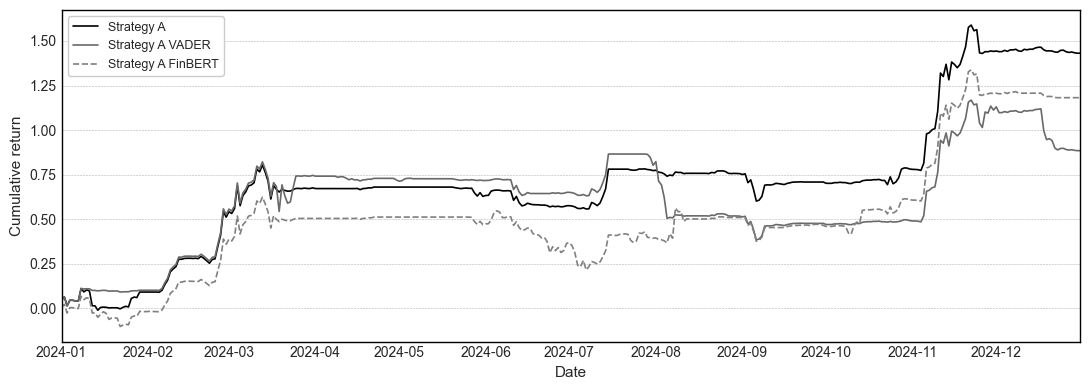

In [360]:
plot_cols = ['stratA_comp', 'stratAVader_ret', 'stratABert_ret']
plot_labels = ["Strategy A", "Strategy A VADER", "Strategy A FinBERT"]

plot_linestyles = ['-', '-', '--', ':', ':', '-.']
plot_linewidths = [1.2, 1.2, 1.2]

oos_mask = df.index > TRAIN_END
oos_df = df.loc[oos_mask].copy()
oos_df['ret_dca_btc'] = dca_ret_oos_reset
oos_cum_returns = cum_curve(oos_df[plot_cols])

plot_cum_returns_bw(
    df=oos_cum_returns,
    cols=plot_cols,
    labels=plot_labels,
    linewidths=plot_linewidths, # Pass the linewidths
    linestyles=plot_linestyles,
    # title="Out-of-Sample Cumulative Returns (2024)",
    filename="fig_returns_OOSothers_improved.png"
)

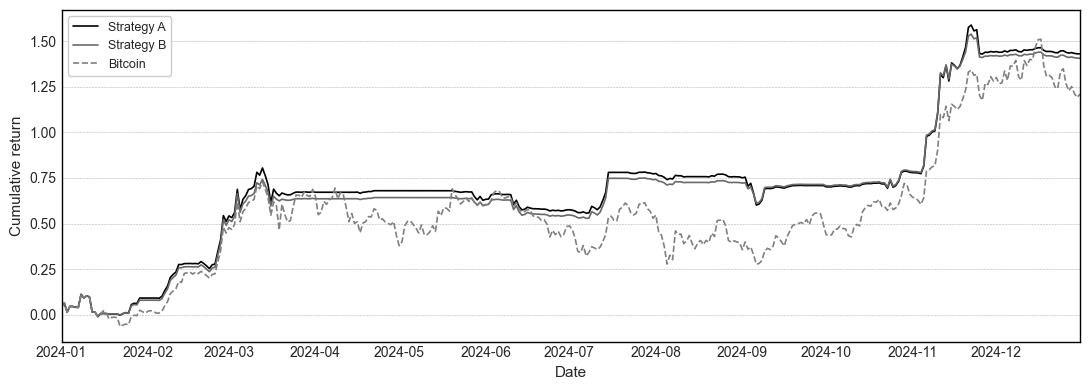

In [361]:
plot_cols = ["stratA_comp", "stratB_comp", "ret_btc"]
plot_labels = ["Strategy A", "Strategy B", "Bitcoin"]

plot_linestyles = ['-', '-', '--', ':', ':', '-.']
plot_linewidths = [1.2, 1.2, 1.2]

oos_mask = df.index > TRAIN_END
oos_df = df.loc[oos_mask].copy()
oos_df['ret_dca_btc'] = dca_ret_oos_reset
oos_cum_returns = cum_curve(oos_df[plot_cols])

plot_cum_returns_bw(
    df=oos_cum_returns,
    cols=plot_cols,
    labels=plot_labels,
    linewidths=plot_linewidths, # Pass the linewidths
    linestyles=plot_linestyles,
    # title="Out-of-Sample Cumulative Returns (2024)",
    filename="fig_returns_OOSothers_improved.png"
)



In [19]:
print("\n--- Correlation to Bitcoin ---")

# Calculate correlations for each period
corr_full_A = df['stratA_comp'].corr(df['ret_btc'])
corr_full_B = df['stratB_comp'].corr(df['ret_btc'])

corr_is_A = df.loc[is_mask, 'stratA_comp'].corr(df.loc[is_mask, 'ret_btc'])
corr_is_B = df.loc[is_mask, 'stratB_comp'].corr(df.loc[is_mask, 'ret_btc'])

corr_oos_A = df.loc[oos_mask, 'stratA_comp'].corr(df.loc[oos_mask, 'ret_btc'])
corr_oos_B = df.loc[oos_mask, 'stratB_comp'].corr(df.loc[oos_mask, 'ret_btc'])

# Create a DataFrame for the results
corr_data = {
    'Strategy A vs Bitcoin': {
        'Full Period': corr_full_A,
        'In-Sample': corr_is_A,
        'Out-of-Sample': corr_oos_A
    },
    'Strategy B vs Bitcoin': {
        'Full Period': corr_full_B,
        'In-Sample': corr_is_B,
        'Out-of-Sample': corr_oos_B
    }
}

corr_table = pd.DataFrame(corr_data)
display(corr_table.round(2))


--- Correlation to Bitcoin ---


,Strategy A vs Bitcoin,Strategy B vs Bitcoin
Full Period,0.58,0.54
In-Sample,0.55,0.51
Out-of-Sample,0.68,0.67



--- 90-Day Rolling Correlation: Strategy A vs Bitcoin ---


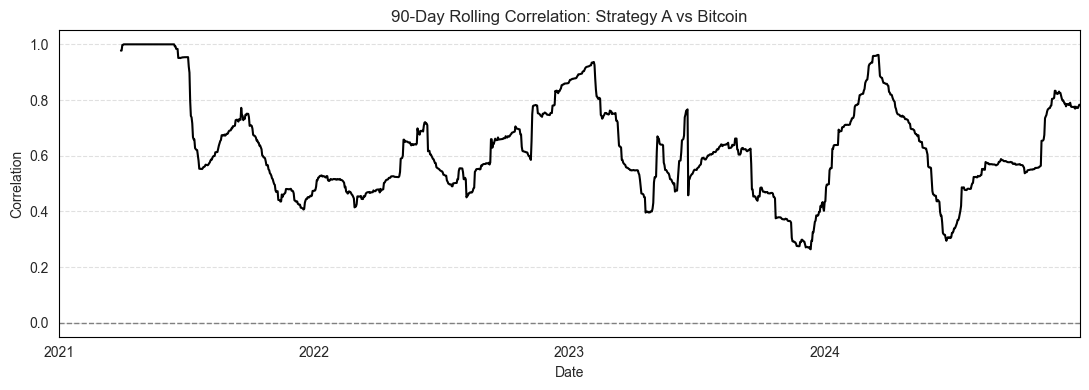

In [20]:
print("\n--- 90-Day Rolling Correlation: Strategy A vs Bitcoin ---")

# Calculate the 90-day rolling correlation
rolling_corr_A = df['stratA_comp'].rolling(window=90).corr(df['ret_btc'])

# Plot the rolling correlation
fig, ax = plt.subplots(figsize=(11, 4))
rolling_corr_A.plot(ax=ax, color='black', lw=1.5)

# Styling
ax.set_title('90-Day Rolling Correlation: Strategy A vs Bitcoin')
ax.set_ylabel('Correlation')
ax.set_xlabel('Date')
ax.axhline(0, color='grey', linestyle='--', lw=1)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
ax.grid(False, axis='x')

for sp in ("top", "right", "left", "bottom"):
    ax.spines[sp].set_color("black")

plt.tight_layout()
plt.savefig("rolling_corr_A_vs_BTC.png", dpi=300, bbox_inches="tight")
plt.show()